In [1]:
import pandas as pd

In [2]:
#df = pd.read_pickle('/content/drive/MyDrive/ironhack_final_project/Imdb_doc2vec_v1.pckl')

In [3]:
#df.shape

In [4]:
#tfidf_df = pd.read_pickle('/content/drive/MyDrive/ironhack_final_project/Imdb_tfidf.pckl')

In [5]:
#tfidf_df.shape

In [6]:
#df = pd.concat([df, tfidf_df], axis=1)

In [7]:
#df.shape

In [8]:
df = pd.read_pickle('/content/drive/MyDrive/ironhack_final_project/Imdb_db_cleaned_merged_final.pckl')

In [9]:
df.shape

(50000, 5192)

In [10]:
df.head(5)

,reviews,sentiment,review_clean,neg,neu,pos,compound,nb_char,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,word_aaron,word_abandon,word_abc,word_ability,word_able,word_aboard,word_abound,word_abraham,word_abrupt,word_abruptly,word_absence,word_absent,word_absolute,word_absolutely,word_absorb,word_absurd,word_absurdity,word_abuse,word_abusive,word_abysmal,word_academy,word_accent,word_accept,word_acceptable,word_acceptance,word_access,...,word_worthless,word_worthwhile,word_worthy,word_would,word_wound,word_wow,word_wrap,word_wreck,word_wrench,word_wrestle,word_wretched,word_write,word_writer,word_writing,word_wrong,word_wtf,word_wwii,word_www,word_ya,word_yard,word_yawn,word_yeah,word_year,word_yearn,word_yell,word_yellow,word_yep,word_yes,word_yesterday,word_yet,word_york,word_young,word_youngster,word_youth,word_youthful,word_youtube,word_zero,word_zombie,word_zone,word_zoom
0,"Having just finished reading the book ""One of ...",0,finish reading book one kind week ago think wo...,0.071,0.820,0.109,0.9364,1629,274,-0.406136,0.168257,-0.180792,0.076184,0.573996,0.0,0.0,0.0,0.091224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.079872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.063739,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,WEEE this is still jolly good fun! As with mos...,1,weee still jolly good fun friend see movie hbo...,0.079,0.747,0.175,0.7895,418,84,-0.080176,0.015398,-0.327595,0.015183,0.200012,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110298,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.262566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Well I guess I know the answer to that questio...,0,well guess know answer question money bombard ...,0.137,0.718,0.145,-0.4044,1227,218,-0.288821,0.038533,-0.339843,0.126955,0.638754,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.086481,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,This is easily one of the best movies of the 1...,1,easily one best movie otto preminger direct fo...,0.079,0.737,0.184,0.9184,628,112,0.460414,0.148562,-0.364555,0.304457,0.196561,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The story is about Ankush (Abhay Deol) - who i...,1,story ankush abhay deol professional marriage ...,0.018,0.735,0.247,0.9992,2628,482,-0.155596,0.596693,-0.176754,0.119736,0.500467,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063412,0.0,0.0,0.0,...,0.0,0.0,0.0,0.054113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploration - 2

In [11]:
# show is_bad_review distribution
df["sentiment"].value_counts().to_frame()

,sentiment
1,25000
0,25000


In [12]:
# highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["reviews", "pos"]].head(10)

,reviews,pos
41569,I smiled through the whole film. The music is ...,0.548
38103,"Great movie, great actors, great soundtrack! I...",0.531
37425,"Great story, great music. A heartwarming love ...",0.528
24206,I LOVE this movie! Beautifully funny and utter...,0.523
32910,The premise is a bit better than the execution...,0.507
13991,this is a great movie. I love the series on tv...,0.506
16638,This is an excellent movie and should be prese...,0.504
49645,This is definitely a girl movie. My husband fo...,0.503
7819,This film ain't half bad. It may be a little l...,0.497
25898,Smallville episode Justice is the best episode...,0.495


In [13]:
# lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("neg", ascending = False)[["reviews", "neg"]].head(10)

,reviews,neg
27040,"This was truly horrible. Bad acting, bad writi...",0.580
11961,Horrible movie. This movie beat out revenge of...,0.466
21824,Horrible movie. This movie beat out revenge of...,0.466
7519,I've seen several of these body snatcher type ...,0.454
22806,"I guess I've seen worse films, but that may be...",0.452
18826,"the tortuous emotional impact is degrading, wh...",0.438
3647,I am the kind of person who can enjoy a good B...,0.438
22388,This pile of sh!t is tied in my book as the wo...,0.428
24763,The English translation of the title on the DV...,0.428
43963,This movie is pathetic in every way possible. ...,0.424


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


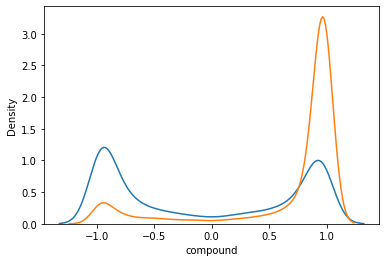

In [14]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = df[df['sentiment'] == x]
    
    # Draw the density plot
    if x == 1:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'],hist = False, label = label)
    

### Train Model 

In [15]:
# feature selection
y_label = "sentiment"
#features = df.drop(label,"review", "review_clean",axis=1)
drop_cols = [y_label, "reviews", "review_clean"]
X_features = [column for column in df.columns if column not in drop_cols]



In [16]:
# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[X_features], df[y_label], test_size = 0.33, random_state = 42)

In [17]:
# train a random forest classifier
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)

In [18]:
# show confusion matrix
print(classification_report(y_test, pred))
print(accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      8230
           1       0.85      0.84      0.84      8270

    accuracy                           0.85     16500
   macro avg       0.85      0.85      0.85     16500
weighted avg       0.85      0.85      0.85     16500

0.845030303030303


Text(0.5, 1.0, 'Confusion Matrix \n Random Forest')

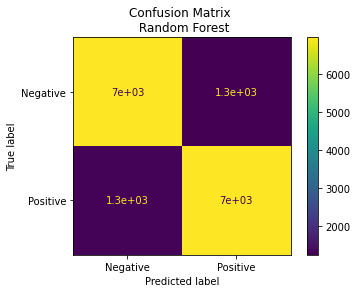

In [19]:
disp = plot_confusion_matrix(rfc, X_test, y_test,
                     display_labels= ["Negative", 'Positive'])

disp.ax_.set_title("Confusion Matrix \n Random Forest")

In [20]:
# show feature importance
feature_importances_df = pd.DataFrame({"feature": X_features, "importance": rfc.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(10)

,feature,importance
3,compound,0.036460
2,pos,0.033540
0,neg,0.033342
356,word_bad,0.024954
7,doc2vec_vector_1,0.015323
10,doc2vec_vector_4,0.013252
6,doc2vec_vector_0,0.012736
2031,word_great,0.011692
5038,word_waste,0.009660
8,doc2vec_vector_2,0.008117


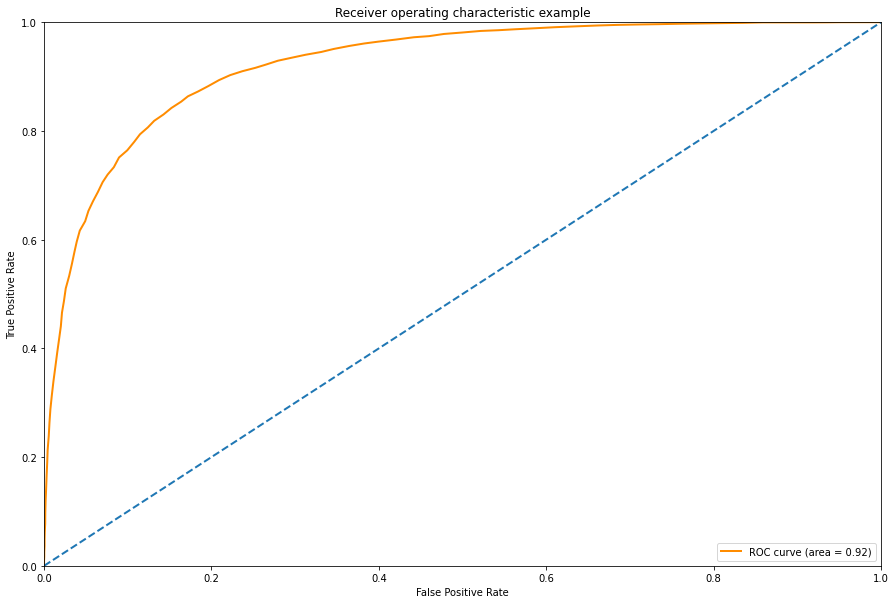

In [21]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rfc.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

This seems to be goood!!!!

In [22]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
#from sklearn.utils.fixes import signature

In [23]:
try:
    from inspect import signature
except ImportError:
    from sklearn.externals.funcsigs import signature

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.92')

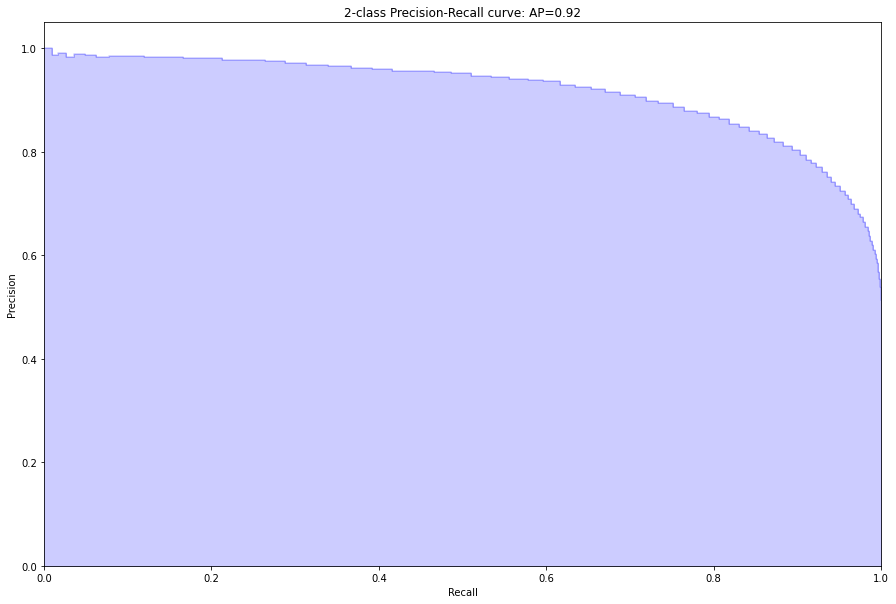

In [24]:
average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

cls_lst = [KNeighborsClassifier(),
          SVC(),
          GaussianProcessClassifier(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          AdaBoostClassifier(),
          GaussianNB(),
          QuadraticDiscriminantAnalysis()
           ]

def evaluate(df, cls):
    accuracies = {}
    
    for cl in cls:

        # feature selection
        y_label = "sentiment"
        #features = df.drop(label,"review", "review_clean",axis=1)
        drop_cols = [y_label, "reviews", "review_clean"]
        X_features = [column for column in df.columns if column not in drop_cols]

        X_train, X_test, y_train, y_test = train_test_split(df[X_features], df[y_label], test_size = 0.33, random_state = 42)
    
        cl.fit(X_train, y_train)
        pred = cl.predict(X_test)
        # print(classification_report(y_test, pred))
        accuracies[cl.__class__.__name__] = accuracy_score(y_test, pred)
        #print(accuracy_score(y_test, pred))
    return accuracies


In [ ]:
accuracy_dict = evaluate(df, cls_lst)

In [ ]:
accuracy_df = pd.DataFrame(accuracy_dict, index=[0])

In [ ]:
accuracy_df.T.plot(kind='bar')